# Benchmark `nlpo3.segment`

Benchmarks nlpO3 (Rust) `nlpo3.segment` (unsafe) against PyThaiNLP (Python) `newmm.segment` (unsafe) using the same dictionary.

https://github.com/PyThaiNLP/nlpo3/

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm


def time_func(func, arg):
    start_time = time.time()
    func(arg)
    return time.time() - start_time

## Load Custom Dictionary to the Tokenizers

Both `o3_newmm()` and `py_newmm()` will use the same word list (`words_th.txt`)

In [2]:
DICT_FILE = "../../words_th.txt"

In [3]:
from pythainlp.tokenize.newmm import segment as py_segment
from pythainlp.util import dict_trie

trie = dict_trie(dict_source=DICT_FILE)

def py_newmm(txt, safe_mode=False):
    return py_segment(txt, safe_mode=safe_mode, custom_dict=trie)

In [4]:
from nlpo3 import load_dict
from nlpo3 import segment as o3_segment

load_dict(DICT_FILE, "test_dict")  # create "test_dict" dictionary

def o3_newmm(txt, safe=False, parallel=False):
    return o3_segment(txt, dict_name="test_dict", safe=safe, parallel=parallel)

Successful: dictionary name test_dict from file ../../words_th.txt has been successfully loaded


## Load Test data

In [5]:
from datasets import load_dataset

datasets = load_dataset('wisesight_sentiment')
datasets

Reusing dataset wisesight_sentiment (/Users/test/.cache/huggingface/datasets/wisesight_sentiment/wisesight_sentiment/1.0.0/fc2b1bdfe79571b2e281e4afdb5aac069cf9270bf0f85694239be672a4191969)


DatasetDict({
    train: Dataset({
        features: ['category', 'texts'],
        num_rows: 21628
    })
    validation: Dataset({
        features: ['category', 'texts'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['category', 'texts'],
        num_rows: 2671
    })
})

In [6]:
txt = datasets['train']['texts'][0]
txt

'ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกรานต์เลย รอขับอยู่นาจา กระทัดรัด เหมาะกับสาวๆขับรถคนเดียวแบบเรา ราคาสบายกระเป๋า ประหยัดน้ำมัน วิ่งไกลแค่ไหนหายห่วงค่ะ'

In [7]:
py_newmm(txt)[:10]

['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

In [8]:
o3_newmm(txt)[:10]

['ไป', 'จอง', 'มา', 'แล้', 'วนา', 'จา', ' ', 'Mitsubishi', ' ', 'Attrage']

## One Example

### Average Run Time for One Example

In [9]:
%timeit py_newmm(txt)

313 µs ± 7.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%timeit o3_newmm(txt)

130 µs ± 5.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit o3_newmm(txt, parallel=True)

219 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit py_newmm(txt, safe_mode=True)

328 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit o3_newmm(txt, safe=True)

134 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## All Examples

### Check If Results Match for All Examples

In [14]:
corrects = [o3_newmm(txt) == py_newmm(txt) for txt in datasets['train']['texts']]
np.mean(corrects), len(corrects)

(0.9999075272794525, 21628)

### Average Run Time Across All Examples

In [15]:
py_newmms = [time_func(py_newmm, txt) for txt in datasets['train']['texts']]
o3_newmms = [time_func(o3_newmm, txt) for txt in datasets['train']['texts']]

# o3 newmm is over 2x faster than python newmm, on average
np.mean(py_newmms), np.mean(o3_newmms), np.mean(py_newmms) / np.mean(o3_newmms)

(0.00020515467866150095, 8.277630043135611e-05, 2.4784229011494605)

(array([1.4746e+04, 3.4960e+03, 1.2480e+03, 8.9000e+02, 4.3000e+02,
        2.3500e+02, 1.4700e+02, 1.0400e+02, 8.0000e+01, 4.7000e+01,
        4.7000e+01, 3.7000e+01, 1.7000e+01, 1.8000e+01, 1.2000e+01,
        1.1000e+01, 7.0000e+00, 8.0000e+00, 9.0000e+00, 5.0000e+00,
        4.0000e+00, 1.2000e+01, 3.0000e+00, 3.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([3.81469727e-06, 6.98169072e-05, 1.35819117e-04, 2.01821327e-04,
        2.67823537e-04, 3.33825747e-04, 3.99827957e-04, 4.65830167e-04,
        5.31832377e-04, 5.97834587e-04, 6.63836797e-04, 7.29839007e-04,
        7.95841217e-04, 8.61843427e-04, 9.27845637e-04, 9.93847847e-04,
        1.05985006e-03, 1.12585227e-03, 1.19185448e-03, 1.25785669e-03,
        1.32385890e-03, 1.38986111e-03, 1.45586332e-03, 1.52186553e-03,
        1.58786774e-03, 1.65386995e-03, 1.71987216e-03, 1.78587437e-03,
        1.85187658e-03, 1.91787879e-03, 1.98388100e-03]),
 <BarContainer object of 30 

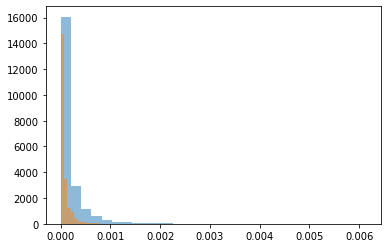

In [16]:
# look at distribution; o3 newmm also consistently performs better
plt.hist(py_newmms, bins=30, alpha=0.5)
plt.hist(o3_newmms, bins=30, alpha=0.5)

## Run Time as Sequence Length Grows

In [17]:
txt = datasets['train']['texts'][1]
txt2 = ''.join(o3_newmm(txt)[:10])
txt2, len(o3_newmm(txt2))

('เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขัน', 10)

In [18]:
py_newmms = [time_func(py_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]
o3_newmms = [time_func(o3_newmm, txt2*i) for i in tqdm([10**j for j in range(5)])]

Performance starts really deviate when sequence length > 10^3 tokens and above.

python newmm is dashed line.

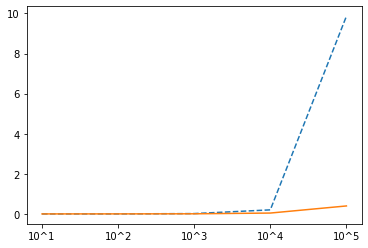

In [19]:
positions = [i for i in range(5)]
labels = [f'10^{i+1}' for i in range(5)]
plt.xticks(positions, labels)
plt.plot(py_newmms, linestyle='dashed')
plt.plot(o3_newmms)

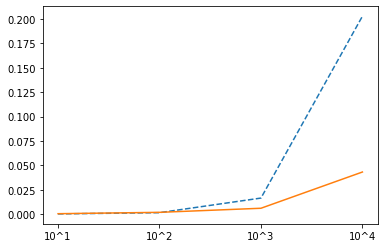

In [20]:
# zooming in on inflexion point
positions = [i for i in range(4)]
labels = [f'10^{i+1}' for i in range(4)]
plt.xticks(positions, labels)
plt.plot(py_newmms[:-1], linestyle='dashed')
plt.plot(o3_newmms[:-1])